In [38]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from astropy import units as u
import scipy.optimize as opt
from photutils import centroids as cent
import lmfit as lm
from lmfit import Minimizer, Parameters, report_fit


class PixelMapFit:
    """Object to hold 2D array of lk.periodgram object data .
    Attributes
    ----------
    targetpixelfile : targetpixelfile object
        
    Optional keywords accepted if ``method='lombscargle'`` are:
            ``minimum_frequency``, ``maximum_frequency``, ``minimum_period``,
            ``maximum_period``, ``frequency``, ``period``, ``nterms``,
            ``nyquist_factor``, ``oversample_factor``, ``freq_unit``,
            ``normalization``, ``ls_method``.
        
    """
    
    def __init__(self, targetpixelfile, gaia=True, magnitude_limit=18, frequencies=[], frequnit=u.uHz, principle_components = 5,aperture=None, **kwargs):

        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        if targetpixelfile.pipeline_mask.any() == False:
            self.aperture = aperture
        else:
            self.aperture = targetpixelfile.pipeline_mask
        self.tpf = targetpixelfile
    
        
        # Make a design matrix and pass it to a linear regression corrector
        self.raw_lc = self.tpf.to_lightcurve(aperture_mask=self.aperture)
        self.dm = lk.DesignMatrix(self.tpf.flux[:, ~self.tpf.create_threshold_mask()], name='regressors').pca(principle_components)
        rc = lk.RegressionCorrector(self.raw_lc)
        corrected_lc = rc.correct(self.dm.append_constant())
        corrected_lc[np.where(corrected_lc.quality == 0)]
        self.corrected_lc = corrected_lc.remove_outliers()
        self.frequency_list = np.asarray((frequencies*frequnit).to(1/u.d))
        self.principle_components = principle_components
        
        def Obtain_Initial_Phase(tpf,corrected_lc,frequency_list):

            flux = corrected_lc.flux.value
            times = corrected_lc.time.value - np.mean(corrected_lc.time.value)
            pg = corrected_lc.to_periodogram(frequency = np.append([0.0001],frequency_list),ls_method='slow')
            initial_flux= np.asarray(pg.power[1:])

            initial_phase = np.zeros(len(frequency_list))

            def lc_model(time,amp,freq,phase):
                return amp*np.sin(2*np.pi*freq*time + phase)

            def background_model(time,height):
                return np.ones(len(time))*height
            for j in np.arange(len(frequency_list)):
                for i in np.arange(len(frequency_list)):

                    if (i == 0):
                        model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                        model += lm.Model(background_model, independent_vars=['time'])
                    else:
                        model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


                    model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phase[i],vary = False)
                    model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=False)
                    model.set_param_hint('height', value= np.mean(flux),vary=False)
                    model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


                params = model.make_params()
                params['f{0:d}phase'.format(j)].set(vary=True)
                params['f{0:d}phase'.format(j)].set(value = initial_phase[j])
                params['f{0:d}phase'.format(j)].set(brute_step=np.pi/10)
                result = model.fit(corrected_lc.flux.value,params,time=times,method = 'brute')
                initial_phase[j]=result.best_values['f{0:d}phase'.format(j)]

            return initial_phase
        
        self.initial_phases = Obtain_Initial_Phase(self.tpf,self.corrected_lc,self.frequency_list)
        
        def Obtain_Final_Phase(tpf,corrected_lc,frequency_list,initial_phases):

            flux = corrected_lc.flux.value
            times = corrected_lc.time.value - np.mean(corrected_lc.time.value)
            pg = corrected_lc.to_periodogram(frequency = np.append([0.0001],frequency_list),ls_method='slow')
            initial_flux= np.asarray(pg.power[1:])


            def lc_model(time,amp,freq,phase):
                return amp*np.sin(2*np.pi*freq*time + phase)

            def background_model(time,height):
                return np.ones(len(time))*height

            for i in np.arange(len(frequency_list)):

                if (i == 0):
                    model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                    model += lm.Model(background_model, independent_vars=['time'])
                else:
                    model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


                model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phases[i],vary = True)
                model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=True)
                model.set_param_hint('height', value= np.mean(flux),vary=True)
                model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


            params = model.make_params()

            result = model.fit(corrected_lc.flux.value,params,time=times)
            
            final_phases = [result.best_values['f{0:d}phase'.format(j)] for j in np.arange(len(frequency_list))]

    
            return final_phases

        self.final_phases = Obtain_Final_Phase(self.tpf,self.corrected_lc,self.frequency_list,self.initial_phases)
    
        def Obtain_Final_Fit(tpf,corrected_lc,frequency_list,final_phases):

            flux = corrected_lc.flux.value
            times = corrected_lc.time.value - np.mean(corrected_lc.time.value)
            pg = corrected_lc.to_periodogram(frequency = np.append([0.0001],frequency_list),ls_method='slow')
            initial_flux= np.asarray(pg.power[1:])


            def lc_model(time,amp,freq,phase):
                return amp*np.sin(2*np.pi*freq*time + phase)

            def background_model(time,height):
                return np.ones(len(time))*height

            for i in np.arange(len(frequency_list)):

                if (i == 0):
                    model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                    model += lm.Model(background_model, independent_vars=['time'])
                else:
                    model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


                model.set_param_hint('f{0:d}phase'.format(i), value= final_phases[i],vary = False)
                model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=True)
                model.set_param_hint('height', value= np.mean(flux),vary=True)
                model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


            params = model.make_params()

            result = model.fit(corrected_lc.flux.value,params,time=times)
            
            return result
        
        
        heats = []
        heats_error =[]
        #Iterating through columns of pixels
        for i in np.arange(0,len(self.aperture)):
            
            #Iterating through rows of pixels
            for j in np.arange(0,len(self.aperture[0])):
                
                
                #Making an empty 2-d array
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = self.tpf.to_lightcurve(aperture_mask=mask)
                rcc = lk.RegressionCorrector(lightcurve)
                lc = rcc.correct(self.dm.append_constant())
                #lc = lc[np.where(lc.quality == 0)]
                #lc = lc.remove_outliers()

                
                
                
                bestfit = Obtain_Final_Fit(self.tpf,lc,self.frequency_list,self.final_phases)
                heat = np.asarray([bestfit.best_values['f{0:d}amp'.format(n)] for n in np.arange(len(self.frequency_list))])
                #heat = bestfit.best_values['f0amp']# / bestfit.params['f0amp'].stderr
                heat_error =  np.asarray([bestfit.params['f{0:d}amp'.format(n)].stderr for n in np.arange(len(self.frequency_list))])
                
                #Extending the list of fitting data for each pixel
                heats.extend([heat])
                heats_error.extend([heat_error])
                
        #Taking the final list and turning it into a 2-d numpy array with the same dimensions of the full postage stamp      
        #heats = np.reshape(np.asarray(heats),(len(self.aperture),len(self.aperture[0])))
        #heats_error = np.reshape(np.asarray(heats_error),(len(self.aperture),len(self.aperture[0])))
        heats = np.asarray(heats)
        heats_error = np.asarray(heats_error)
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.heatmap = heats.T
        self.heatmap_error = heats_error.T
        self.timeserieslength = (self.tpf.time.max()-self.tpf.time.min()).value
        self.gaiadata = None
        
        if (gaia == True):
            """Make the Gaia Figure Elements"""
            # Get the positions of the Gaia sources
            c1 = SkyCoord(self.tpf.ra, self.tpf.dec, frame='icrs', unit='deg')
            # Use pixel scale for query size
            pix_scale = 4.0  # arcseconds / pixel for Kepler, default
            if self.tpf.mission == 'TESS':
                pix_scale = 21.0
            # We are querying with a diameter as the radius, overfilling by 2x.
            from astroquery.vizier import Vizier
            Vizier.ROW_LIMIT = -1
            result = Vizier.query_region(c1, catalog=["I/345/gaia2"],radius=Angle(np.max(self.tpf.shape[1:]) * pix_scale, "arcsec"))

            no_targets_found_message = ValueError('Either no sources were found in the query region '
                                                      'or Vizier is unavailable')
            too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
            if result is None:
                raise no_targets_found_message
            elif len(result) == 0:
                raise too_few_found_message
            result = result["I/345/gaia2"].to_pandas()

            result = result[result.Gmag < magnitude_limit]
            if len(result) == 0:
                raise no_targets_found_message

            year = ((self.tpf.time[0].jd - 2457206.375) * u.day).to(u.year)
            pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            result.RA_ICRS += pmra
            result.DE_ICRS += pmdec
            radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
            coords = self.tpf.wcs.all_world2pix(radecs, 0) 



            # Gently size the points by their Gaia magnitude
            sizes = 64.0 / 2**(result['Gmag']/5.0)
            one_over_parallax = 1.0 / (result['Plx']/1000.)
            source = dict(ra=result['RA_ICRS'],
                          dec=result['DE_ICRS'],
                          source=result['Source'].astype(str),
                          Gmag=result['Gmag'],
                          plx=result['Plx'],
                          one_over_plx=one_over_parallax,
                          x=coords[:, 0],
                          y=coords[:, 1],
                          size=sizes)


            self.gaiadata = source
        class frequency_heatmap:

            def __init__(self,tpf,heats,heats_error,frequencies,gaia_data):
                self.heat_stamp = heats
                self.gaiadata=gaia_data
                self.heatmap_error = heats_error
                self.size = tpf.pipeline_mask.shape
                self.frequencies= frequencies
            def centroid(self):
                
                #Residuals to minimize relative to the error bars
                def residual(params, amp, amperr):
                    
                    x = params['x']
                    y = params['y']
                    sigma = params['sigma']

                    xpix,ypix = np.meshgrid(np.arange(self.size[0]),np.arange(self.size[1]))
                    
                    res = []
                    for i in np.arange(len(self.frequencies)):
                        height = params['height{0:d}'.format(i)]
                        
                        model = height*np.exp(-(((x-xpix)/sigma)**2+((y-ypix)/sigma)**2)/2)
                        
                        res.extend( [(amp[i].reshape(self.size)-model) / amperr[i].reshape(self.size)])
                        

                    return np.asarray(res)

                #Set starting values to converge from
                self.heatmap_error[np.where(self.heatmap_error==None)]=np.nan
                composite_heatmap = self.heat_stamp.sum(axis=0).reshape(self.size) / ((np.nansum(self.heatmap_error**2,axis=0))**(1/2)).reshape(self.size)#issue with numpy using sqrt?
                c = np.where(composite_heatmap==composite_heatmap.max())
                params = Parameters()
                for i in np.arange(len(frequencies)):
                    params.add('height{0:d}'.format(i), value=np.max(self.heat_stamp[i]))
                params.add('x', value=c[1][0]) 
                params.add('y', value=c[0][0])
                params.add('sigma', value=1)
                
                #Do the fit
                minner = Minimizer(residual, params, fcn_args=(self.heat_stamp, self.heatmap_error))
                self.result = minner.minimize()
                fit = self.result.params.valuesdict()
                self.x = fit['x']
                self.y = fit['y']

                
            def star_list(self):
                gaia_data = self.gaiadata
                no_gaia_data_message = ValueError('No gaia data initialized in PixelMapPeriodogram class')
                if gaia_data ==None :
                    raise no_gaia_data_message

                else:
                    distances = np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])
                    closest_star_mask = np.where(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])==(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])).min())
                    stars = dict(ra = np.asarray(gaia_data['ra']),
                                 dec = np.asarray(gaia_data['dec']),
                                 source = np.asarray(gaia_data['source']),
                                 x = np.asarray(gaia_data['x']),
                                 y = np.asarray(gaia_data['y']),
                                 distance = distances,
                                 probability = 2*stats.norm.sf(distances,scale=np.sqrt(self.result.params['x'].stderr**2 +self.result.params['y'].stderr**2 )))#I believe mutiply by 2 since we wont have a negative distance
                    starlist = pd.DataFrame.from_dict(stars)
                    self.stars = starlist.sort_values(by=[r'distance'])
                    
        fh = frequency_heatmap(self.tpf,self.heatmap,self.heatmap_error,self.frequency_list,self.gaiadata) 
        fh.centroid()
        fh.star_list()
        self.centroid = [fh.x,fh.y]
        self.heatmap = self.heatmap.sum(axis=0).reshape(self.aperture.shape[0],self.aperture.shape[1]) / np.sqrt((self.heatmap_error**2).sum(axis=0)).reshape(self.aperture.shape[0],self.aperture.shape[1])
        self.starfit= fh.stars.reset_index()
        self.result = fh.result
    
    def info(self):
        plt.imshow(self.heatmap,origin='lower')
        #plot the centroid
        if (self.gaiadata != None):
            plt.scatter(self.gaiadata['x'],self.gaiadata['y'],s=self.gaiadata['size']*5,c='white',alpha=.6)
            plt.scatter(self.centroid[0],self.centroid[1],marker='X',s=100)
            
        plt.xlim(-.5,self.aperture.shape[1]-1+.5)
        plt.ylim(-.5,self.aperture.shape[0]-1+.5)
        print(self.starfit)
        report_fit(self.result)
    
    def pca(self):
        plt.figure(figsize=(12,5))
        plt.plot(self.tpf.time.value, self.dm.values + np.arange(self.principle_components)*0.2)
        plt.title('Principle Components Contributions')
        plt.xlabel('Offset')
        g2 = self.raw_lc.plot(label='Raw light curve')
        self.corrected_lc.plot(ax=g2, label='Corrected light curve')

        plt.show()



In [26]:
frequency_list = [9.51112996, 19.02225993, 28.53338989, 38.04451986, 47.55564982, 57.06677979, 66.57790975, 76.08903972]

In [3]:
search_result = lk.search_targetpixelfile('TIC117070953')
tpf = search_result.download(quality_bitmask='default')

C:\Users\higgi\anaconda3\lib\site-packages\lightkurve\search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [39]:
test = PixelMapFit(targetpixelfile=tpf, gaia=True, magnitude_limit=18, frequencies=frequency_list, frequnit=u.uHz, principle_components = 3)

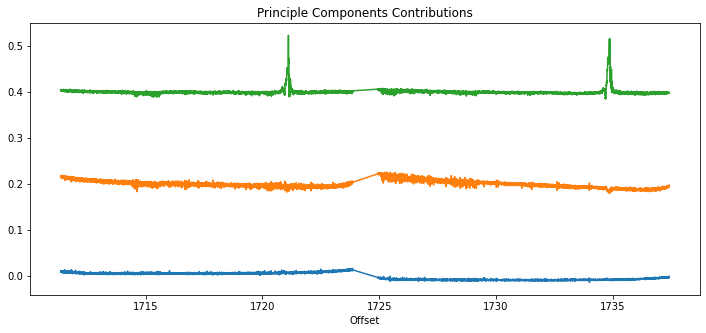

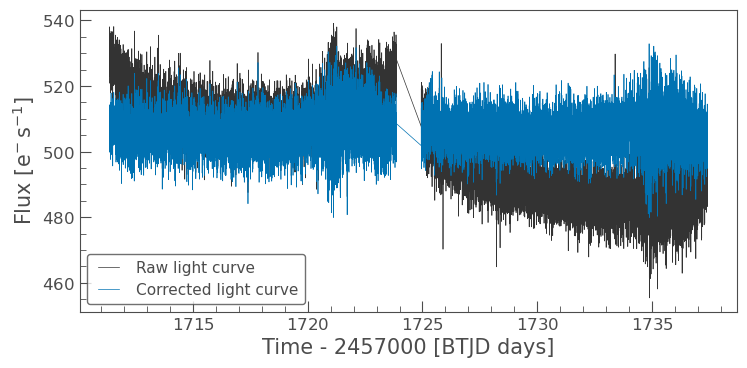

In [40]:
test.pca()

     index          ra        dec               source          x          y  \
0       89  319.294964  34.196133  1855294415817908480   5.876951   2.998218   
1       92  319.295630  34.196130  1855294415817907840   5.961744   2.957995   
2       75  319.292226  34.192087  1855294312738692480   5.237045   2.537803   
3       98  319.291908  34.201217  1855294415817910144   5.852838   3.964698   
4       86  319.289577  34.200021  1855294312738695296   5.469589   3.919459   
..     ...         ...        ...                  ...        ...        ...   
219    187  319.258799  34.263911  1855295545386531840   6.141734  15.608942   
220    208  319.289020  34.270607  1855295893286678272  10.473577  14.837415   
221    223  319.241740  34.258541  1867305137241296768   3.582052  15.799980   
222    219  319.216185  34.237633  1867304999802343552  -1.178783  14.104036   
223    185  319.256403  34.267368  1855295549689299840   6.085194  16.285082   

       distance  probability  
0      0

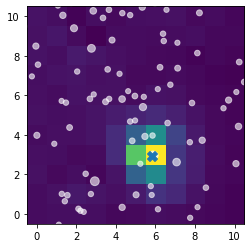

In [41]:
test.info()